# Stiching.ipynb
By: **SHAWN VOSBURG** (260743167)   
Date: October 22th, 2018  
Class: ECSE415  

## 1.Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.

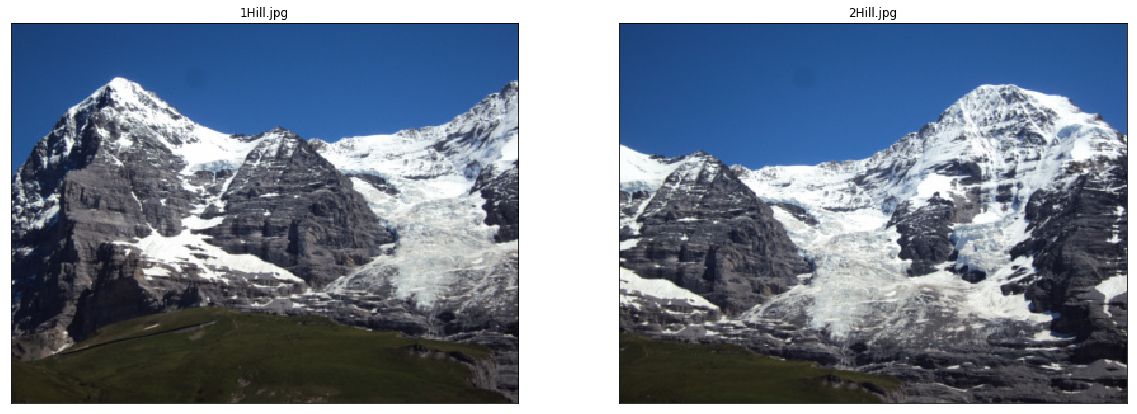

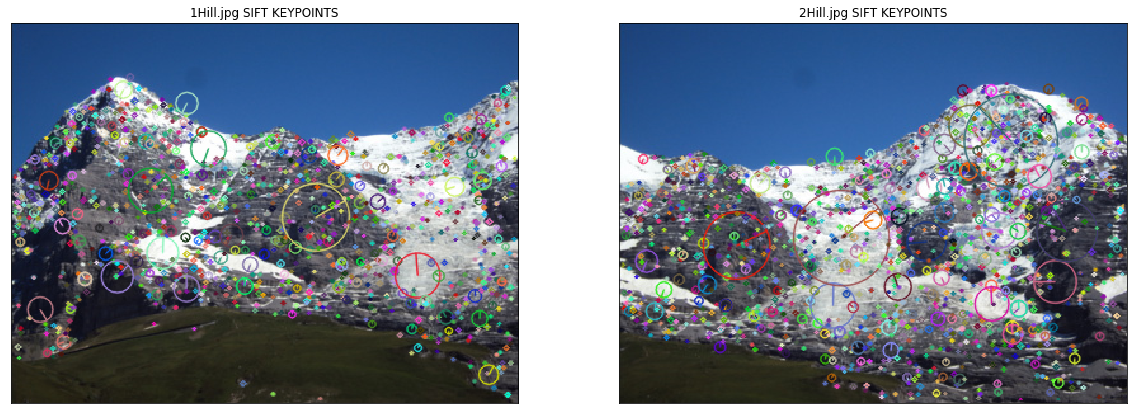

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# loading images
img1 = cv2.imread("./stitching_images/1Hill.jpg")
img2 = cv2.imread("./stitching_images/2Hill.jpg")

#Crop out ugly white border. Creating display images. Converting images to RGB
def cropWhiteBorder(img):
    cropAmount = 0 #was 1, reset to 0 for testing with white border. 
    return img[cropAmount:img.shape[0]-cropAmount, cropAmount:img.shape[1]-cropAmount]
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1 = cropWhiteBorder(img1)
img2 = cropWhiteBorder(img2)
img1_disp = img1.copy()
img2_disp = img2.copy()


#Creating sift object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)


# draw the keypoints. 3rd argument is outputimage. 
cv2.drawKeypoints(img1, keypoints1, img1_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img2, keypoints2, img2_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display keypoints as a visual check.
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img1)
plt.title("1Hill.jpg"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2)
plt.title("2Hill.jpg"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img1_disp)
plt.title("1Hill.jpg SIFT KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img2_disp)
plt.title("2Hill.jpg SIFT KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.show()


## 2. Find matching keypoints in two images and display the 20 best pairs.


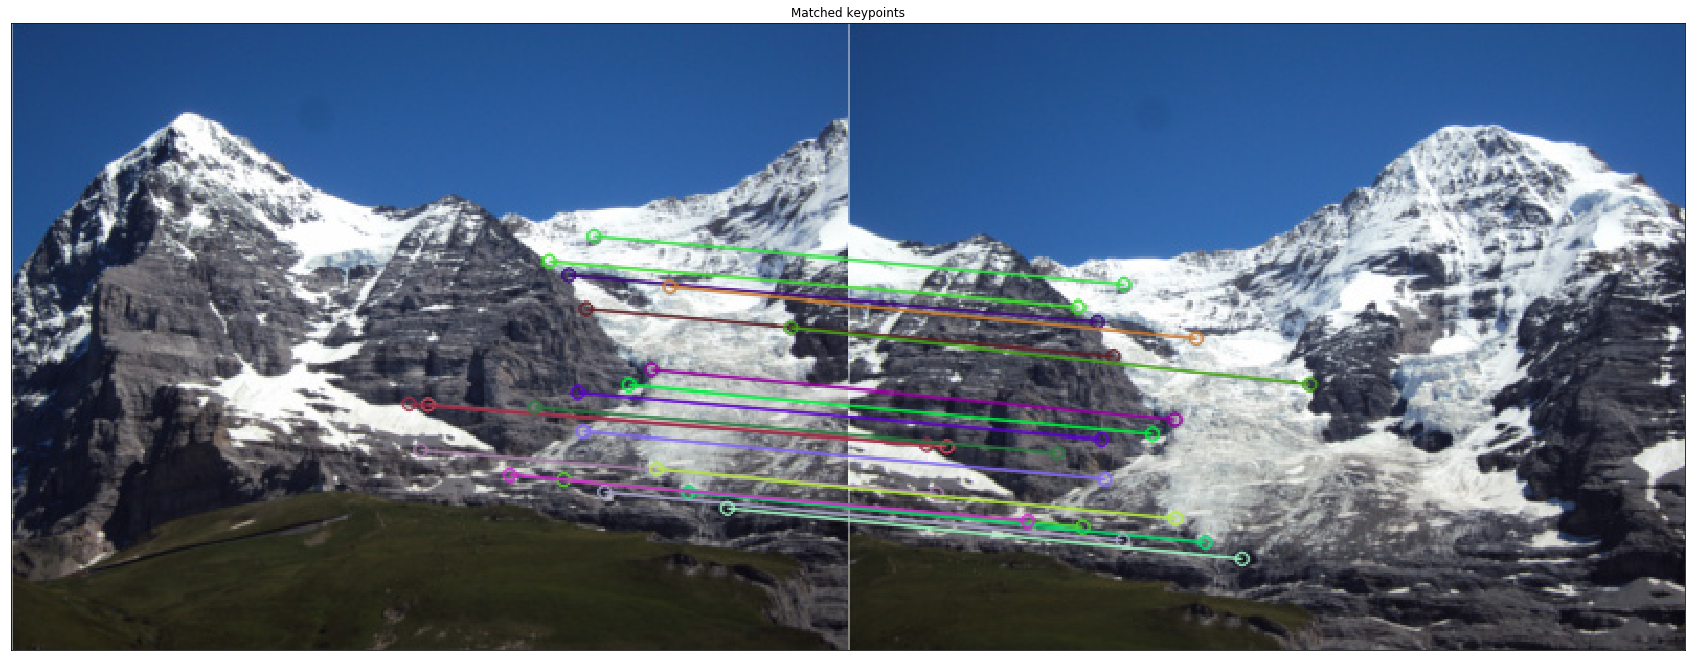

In [3]:
# create BruteForceMatcher object
BF = cv2.BFMatcher()

# Match descriptors
matches = BF.match(descriptors1,descriptors2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw best 20 matches.
imgMatched12 = cv2.drawMatches(img1,keypoints1,img2,keypoints2, matches[:20], img1, flags=2)

plt.figure(figsize=(30,30))
plt.imshow(imgMatched12)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

## 3.Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

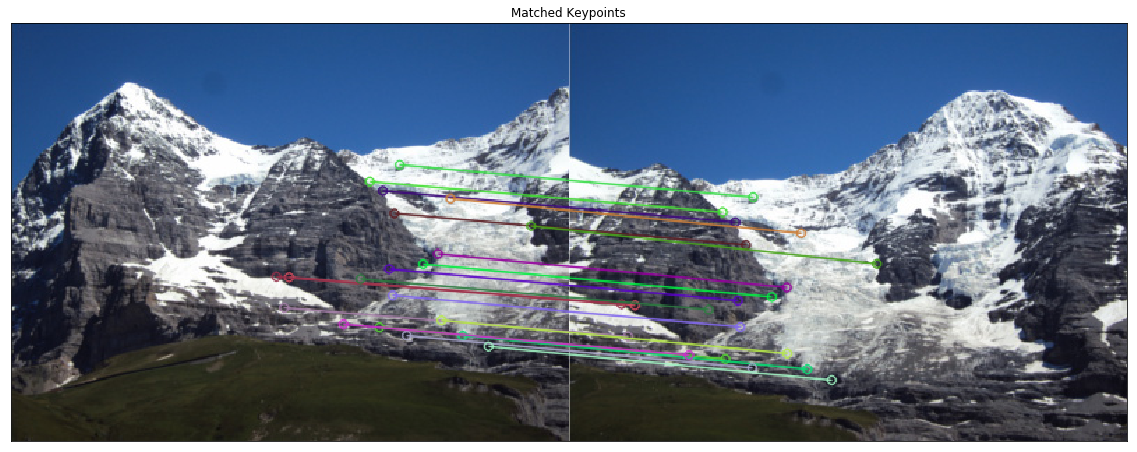

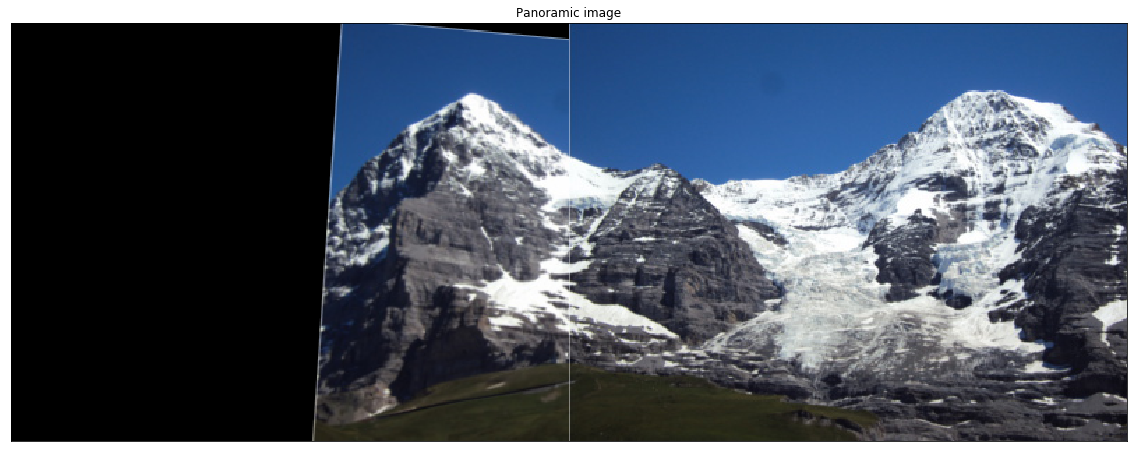

In [4]:
#create copy of 1Hill and 2Hill to not overwrite them
img1H = img1.copy()
img2H = img2.copy()

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints2[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints1[i].pt for (__, i) in GoodMatches])

#Must modify the x-val of the points for the right image since they are "img2H.shape[1]"" pixels to the right.
for i in range(len(mpr)):
    mpr[i][0] += img2H.shape[1]

# find homography and wrap image accordingly. Also applying translation matrix M so that there is no clipping
def translationMatrix(deltaX, deltaY): #Create function for translation matrix
    return np.float32([[1,0,deltaX],[0,1,deltaY],[0,0,1]])  

HomoMat, __ = cv2.findHomography(mpl, mpr, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img1H, HomoMat, (img2H.shape[1]+img1H.shape[1],img2H.shape[0]))
#save images for later
imgl = wimg.copy()
imgr = np.zeros((img2H.shape[0],img2H.shape[1]+img1H.shape[1],3), dtype=np.uint8)
imgr[:img2H.shape[0],img1H.shape[1]:,:] = img2H
wimg[:img2H.shape[0],img1H.shape[1]:,:] = img2H


plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(imgMatched12)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(wimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

## 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

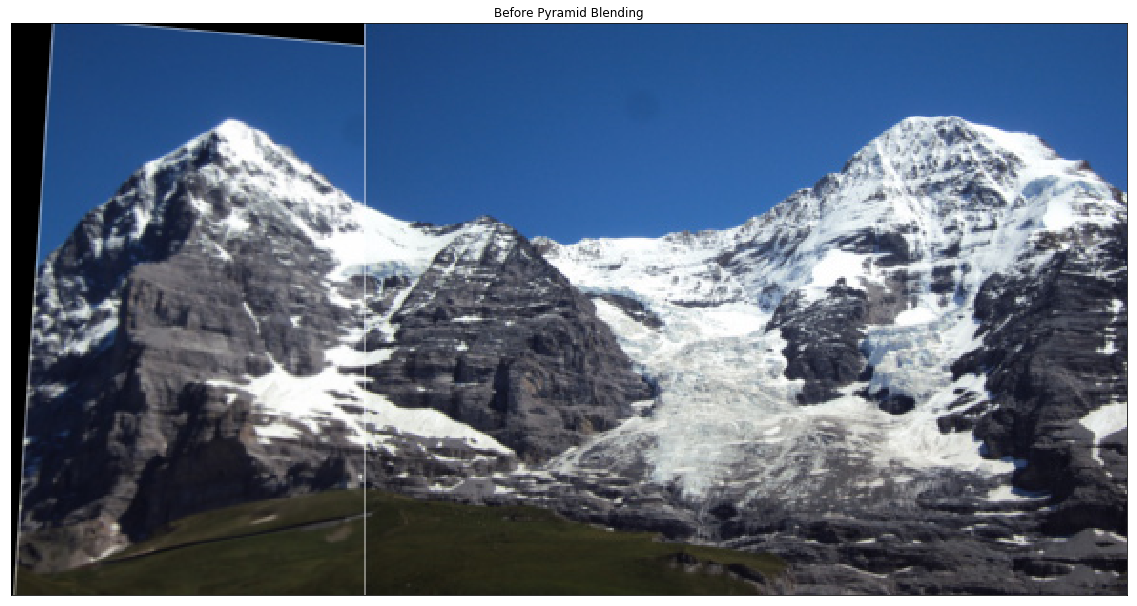

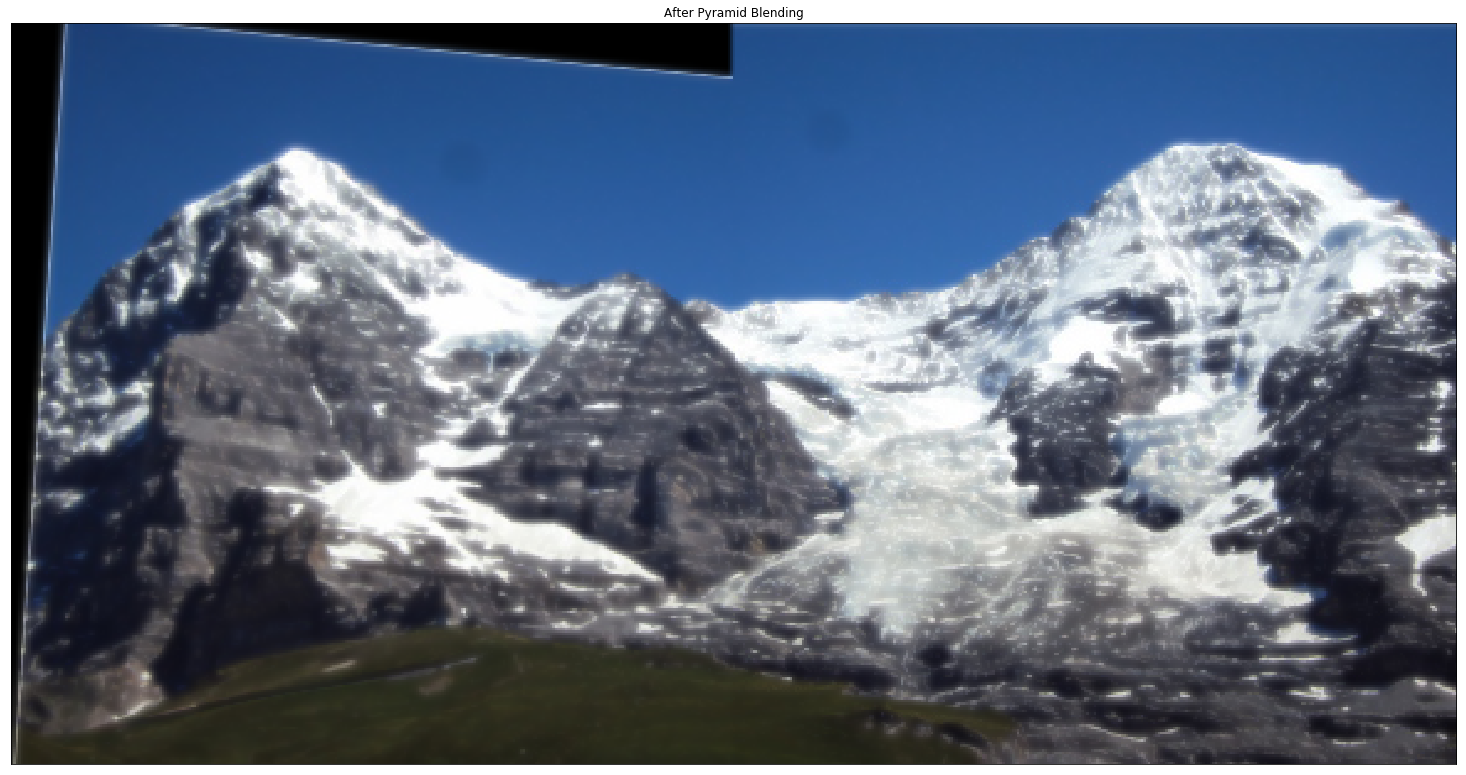

In [5]:
#Create image copies
imgA = imgl.copy()
imgB = imgr.copy()

#control pyramid depth
depth = 2

#Returns x,y,w,h of bbox
def findBoundingBox(img,minThresh):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret,thresholded = cv2.threshold(grayscale, minThresh, 255,cv2.THRESH_BINARY)
    return cv2.boundingRect(thresholded)

#Determining the clipping left. Idea: Trying to remove the most amount of black possible to avoid strange artifacts. 
xLeft = findBoundingBox(imgA,0)[0]
imgA = imgA[:,xLeft:]
imgB = imgB[:,xLeft:]

#Determine Shape and create un-blended image before blending
h,w,d = imgB.shape
real = imgA.copy()
x, y, w, h = findBoundingBox(imgB,0)
real[y:y+h, x:x+w] = imgB[y:y+h, x:x+w]

#create function that build gaussian and laplacian pyramid
def gaussianPyr (img, depth):
    layer = img.copy()
    gaussian_pyramid = [layer]
    for i in range(depth):
        layer = cv2.pyrDown(layer)
        gaussian_pyramid.append(layer)
    return gaussian_pyramid

def laplacianPyr(depth, gaussian_pyramid):
    layer = gaussian_pyramid[depth-1]
    laplacian_pyramid = [layer]
    for i in range(depth-1, 0, -1):
        size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

# Gaussian Pyramid 1 & Laplacian Pyramid 1
gauss1 = gaussianPyr(imgA,depth)
lap1 = laplacianPyr(depth, gauss1)
 
# Gaussian Pyramid 2 & Laplacian Pyramid 2
gauss2 = gaussianPyr(imgB,depth)
lap2 = laplacianPyr(depth, gauss2)
 
# Laplacian Pyramid merged together
lap12 = []
for imgA_lap, imgB_lap in zip(lap1, lap2):
    cols, rows, ch = imgA_lap.shape
    laplacian = imgA_lap.copy()
    laplacian = np.hstack((imgA_lap[:, 0:int(rows/2)], imgB_lap[:, int(rows/2):]))
    lap12.append(laplacian)
    
# Reconstructed Mountain
mountBlended = lap12[0]
for i in range(1, depth):
    size = (lap12[i].shape[1], lap12[i].shape[0])
    mountBlended = cv2.pyrUp(mountBlended, dstsize=size)
    mountBlended = cv2.add(lap12[i], mountBlended)


plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(real)
plt.title("Before Pyramid Blending"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(30,30))
plt.subplot(211)
plt.imshow(mountBlended)
plt.title("After Pyramid Blending"), plt.xticks([]), plt.yticks([])
plt.show()

## Let’s call the above resulting image 12Hill. Implement the following steps to stitch 12Hill and 3Hill.  

## 5. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

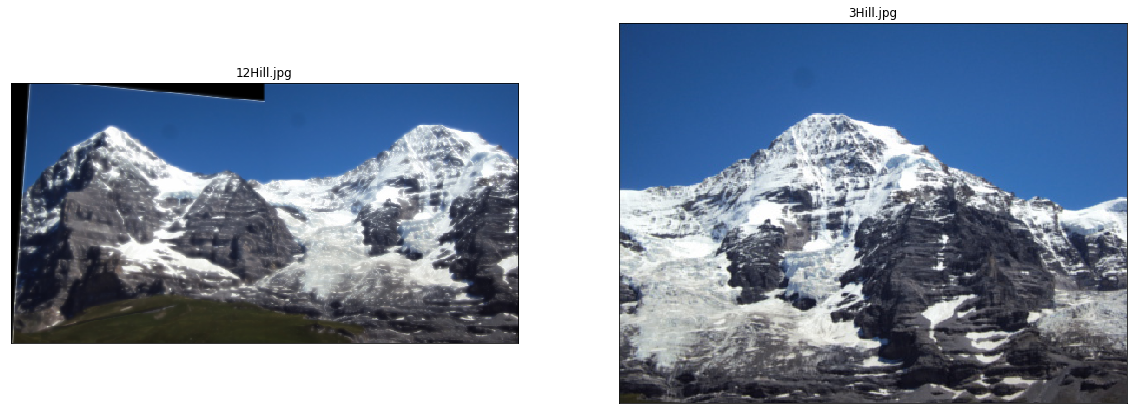

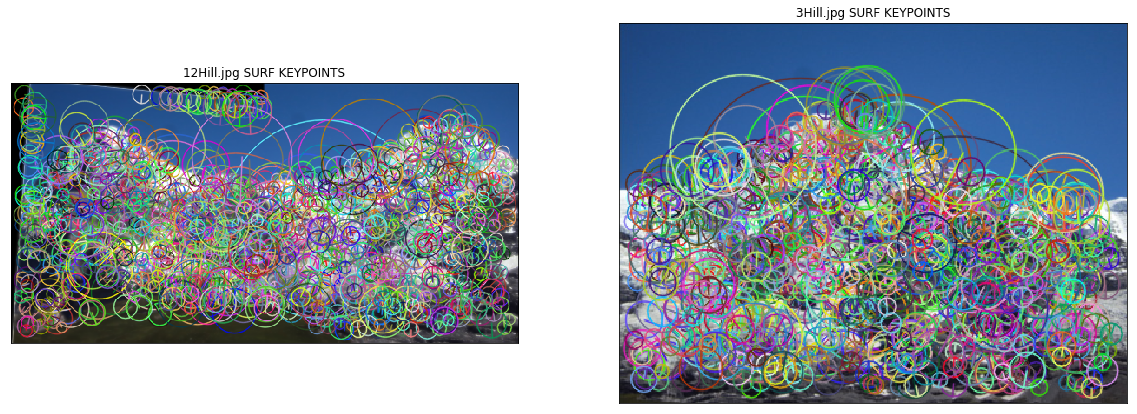

In [6]:
# loading images
img12 = mountBlended.copy()
img3 = cv2.imread("./stitching_images/3Hill.jpg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#Creating display images. Converting images to RGB
img3 = cropWhiteBorder(img3)
img12_disp = img12.copy()
img3_disp = img3.copy()

#Creating sift object
surf = cv2.xfeatures2d.SURF_create()

# detect SIFT features, with no masks
keypoints12, descriptors12 = surf.detectAndCompute(img12, None)
keypoints3, descriptors3 = surf.detectAndCompute(img3, None)

# draw the keypoints. 3rd argument is outputimage. 
cv2.drawKeypoints(img12, keypoints12, img12_disp, flags=6)
cv2.drawKeypoints(img3, keypoints3, img3_disp, flags=6)

# display keypoints as a visual check.
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img12)
plt.title("12Hill.jpg"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img3)
plt.title("3Hill.jpg"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img12_disp)
plt.title("12Hill.jpg SURF KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img3_disp)
plt.title("3Hill.jpg SURF KEYPOINTS"), plt.xticks([]), plt.yticks([])
plt.show()

## 6. Find matching keypoints in two images and display the 20 best pairs

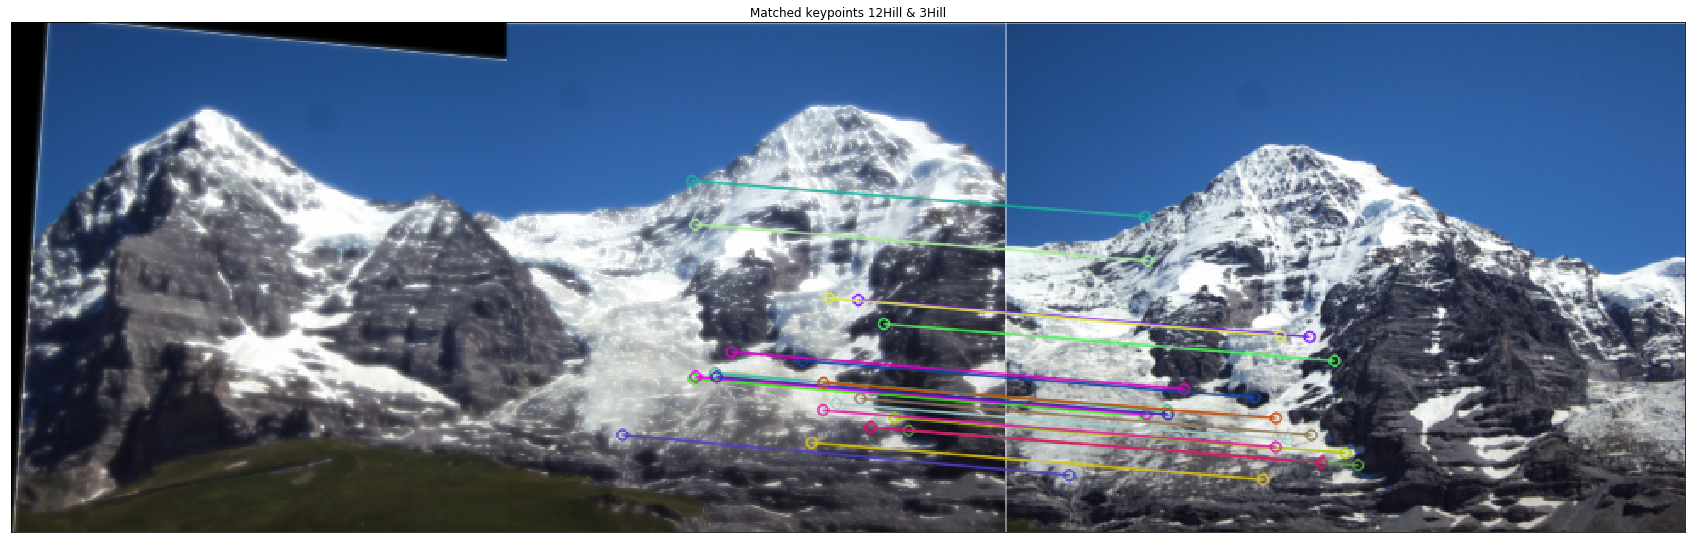

In [7]:
# create BruteForceMatcher object
BruteF = cv2.BFMatcher()

# Match descriptors
matches = BruteF.match(descriptors12,descriptors3)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
imgMatched123 = cv2.drawMatches(img12,keypoints12,img3,keypoints3, matches[:20], img12, flags=2)

plt.figure(figsize=(30,30))
plt.imshow(imgMatched123)
plt.title("Matched keypoints 12Hill & 3Hill"), plt.xticks([]), plt.yticks([])
plt.show()

## 7. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

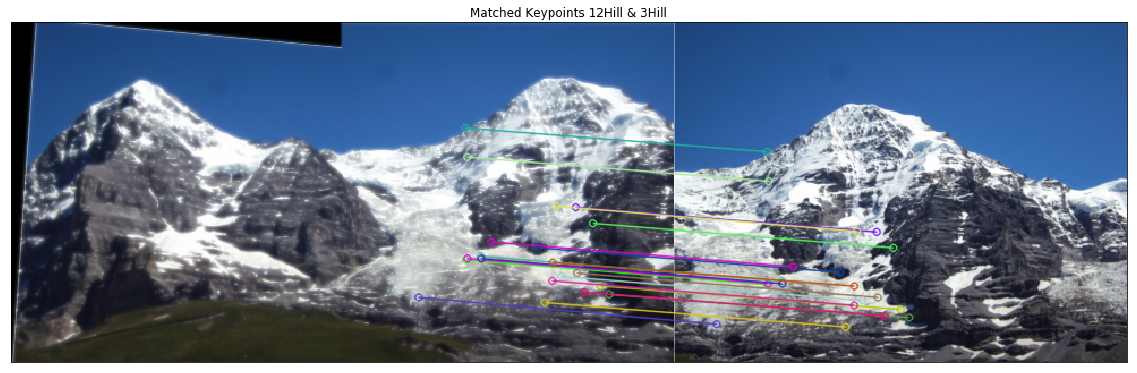

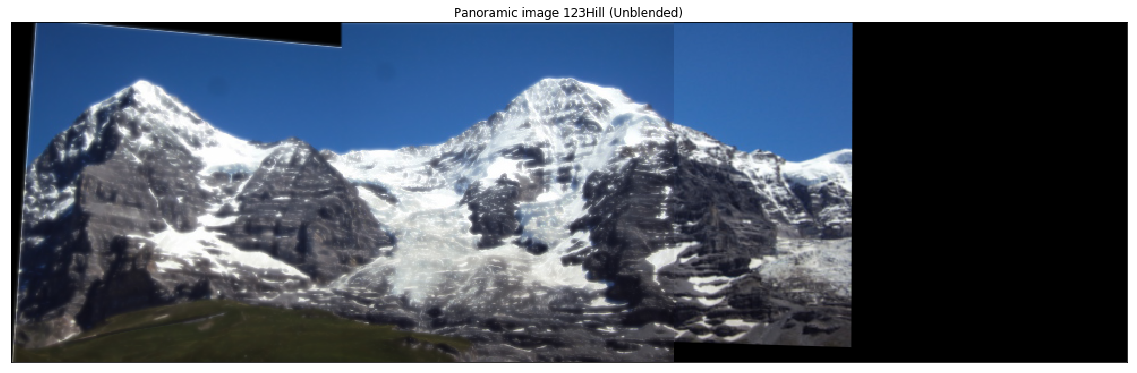

In [8]:
#create copy of 1Hill and 2Hill to not overwrite them
img12H = img12.copy()
img3H = img3.copy()

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints3[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints12[i].pt for (__, i) in GoodMatches])

#Must modify the x-val of the points for the right image since they are "img2H.shape[1]"" pixels to the right.
for i in range(len(mpr)):
    mpr[i][0] += img12H.shape[1]

# find homography and wrap image accordingly. Also applying translation matrix M so that there is no clipping
N = translationMatrix(img12H.shape[1],0) #used to move right image right by img12H.shape[1].
HomoMat2, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img3H, HomoMat2.dot(N), (img3H.shape[1]+img12H.shape[1],img12H.shape[0]))
#save images for later
imgr = wimg.copy()
imgl = np.zeros((img12H.shape[0],img12H.shape[1]+img3H.shape[1],3), dtype=np.uint8)
imgl[:img12H.shape[0],:img12H.shape[1],:] = img12H
wimg[:img12H.shape[0],:img12H.shape[1],:] = img12H
    

plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(imgMatched123)
plt.title("Matched Keypoints 12Hill & 3Hill"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(wimg)
plt.title("Panoramic image 123Hill (Unblended)"), plt.xticks([]), plt.yticks([])
plt.show()

## 8. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

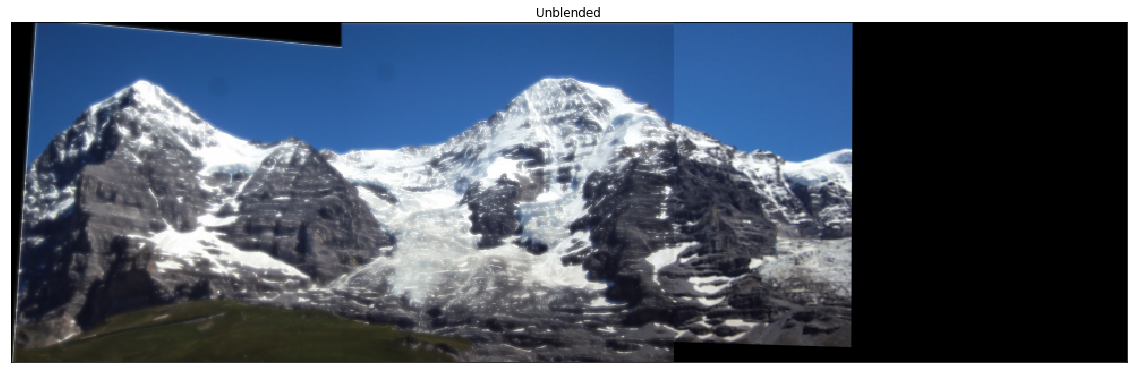

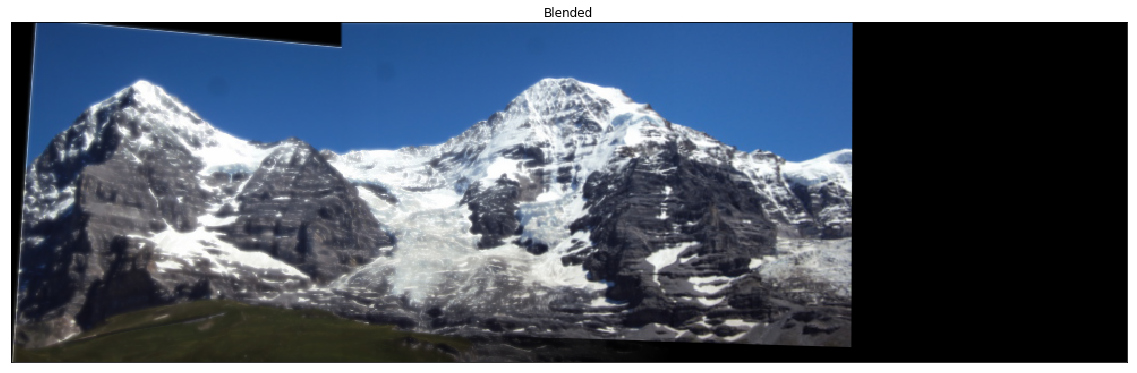

In [9]:
#Create copies of images
imgA = imgl.copy()
imgB = imgr.copy()

#Find intersection of both images.
grayscaleA = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
ret,thresholdedA = cv2.threshold(grayscaleA, 0, 255,cv2.THRESH_BINARY)
grayscaleB = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)
ret,thresholdedB = cv2.threshold(grayscaleB, 0, 255,cv2.THRESH_BINARY)
intersection = cv2.bitwise_and(thresholdedA,thresholdedB)
xi,yi,wi,hi = cv2.boundingRect(intersection)

Unblended = wimg.copy()
#Manually doing feathering
Blended = np.zeros((imgA.shape[0],imgA.shape[1],3))
ramp_size = wi
for x in range(Blended.shape[1]):
    for y in range(Blended.shape[0]):
        if(x <= xi):
            Blended[y][x] = imgA[y][x]
        elif(xi< x  and x <= xi + wi):
            percentB = (x-xi)/ramp_size
            percentA = 1-percentB
            Blended[y][x] = percentA * imgA[y][x] + percentB * imgB[y][x]
        else:
            Blended[y][x] = imgB[y][x]
Blended = np.uint8(Blended)  # convert back to uint8

plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(Unblended)
plt.title("Unblended"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(Blended)
plt.title("Blended"), plt.xticks([]), plt.yticks([])
plt.show()

# 2.2 Reasoning Questions

## 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. 

Answer: SURF is an estimation of keypoint finding that uses fast hessian and box filters to achieve what SIFT does from 3-6 times faster generally. However, SURF has some major disadvantages. It does not find as many points as SIFT and it is more sensible to rotations in POV and in illumination. The example below demonstrates the differences stated above about SIFT and SURF. 

Time for SIFT keypoints: 0.08069729804992676 seconds.
Time for SURF keypoints: 0.09571218490600586 seconds.
Number of SIFT keypoints:  1254
Number of SURF keypoints:  896


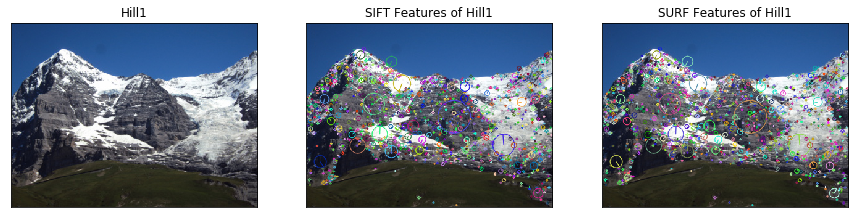

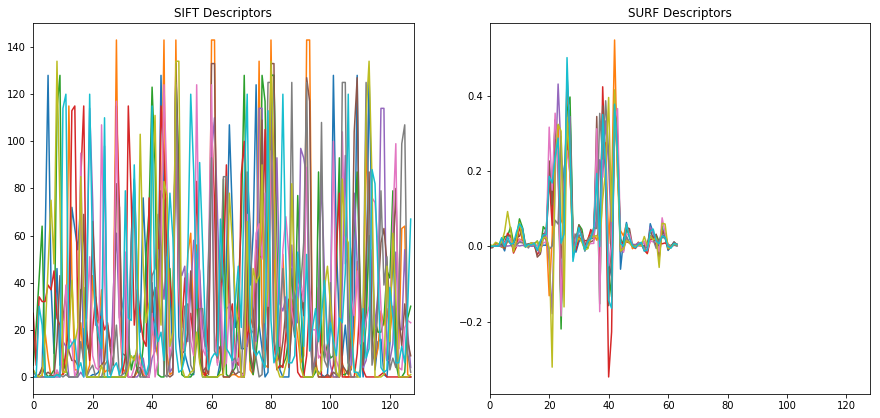

In [10]:
import time
imgRQ = cv2.imread("./stitching_images/1Hill.jpg")
imgRQ = cv2.cvtColor(imgRQ, cv2.COLOR_BGR2RGB)
imgRQSiftKeys = imgRQ.copy()
imgRQSurfKeys = imgRQ.copy()
imgRQgray = cv2.cvtColor(imgRQ, cv2.COLOR_BGR2GRAY)

#Compute SIFT keypoints
siftRQ = cv2.xfeatures2d.SIFT_create()
ti = time.time()
keySift, descSift = sift.detectAndCompute(imgRQgray, None)
tf = time.time()
cv2.drawKeypoints(imgRQ, keySift, imgRQSiftKeys, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("Time for SIFT keypoints:",tf-ti,"seconds.")

#Compute SURF keypoints
surfRQ = cv2.xfeatures2d.SURF_create()
ti = time.time()
keySurf, descSurf = surf.detectAndCompute(imgRQgray, None)
tf = time.time()
cv2.drawKeypoints(imgRQ, keySift, imgRQSurfKeys, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("Time for SURF keypoints:",tf-ti,"seconds.")

print("Number of SIFT keypoints: ", len(keySift))
print("Number of SURF keypoints: ", len(keySurf))


# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(imgRQ)
plt.title("Hill1"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(imgRQSiftKeys)
plt.title("SIFT Features of Hill1"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(imgRQSurfKeys)
plt.title("SURF Features of Hill1"), plt.xticks([]), plt.yticks([])
plt.show()

# display SIFT descriptors
plt.figure(figsize=(15,15))
plt.subplot(221)
for i in range(10):
    plt.plot(descSift[i])
    plt.xlim([0,128]) # set x-axis limit
    plt.title("SIFT Descriptors")

# display SURF descriptors
plt.subplot(222)
for i in range(10):
    plt.plot(descSurf[i])
    plt.xlim([0,128]) # set x-axis limit
    plt.title("SURF Descriptors")
plt.show()


## 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?


**Pyramid Blending**:  
Pros: 1. Pyramid blending keeps high frequency portion of images intact (see pyramid blended images where the black border does not mix with the image). 2. Haing variable pyramid depth permits easy code recycling for different image blending.  
Cons: 1. May introduce aliases due to subsampling. For example,the white of the 12Hill mountain seems to wash off onto the blue sky. 2. Is harder to implement than linear blending.

**Linear Blending**:  
Pros: 1. Easy to implement. 2. Fast algorithm.   
Cons: 1. Introduces translucent-like artifacts when blending high frequency images. For example, see 123Hill where the bottom of 12Hill is seems to dissapear into the darkness of the black border of 3Hill. 2. Must have a large overlap between images in order to have a smooth blending. Having a small area of intersection between images may cause an irrealistic sharp transition, especially if there is a difference of illumination between images. 


Pyramid Blending should be prefered over linear blending when the images to be blend do not share the same shape. Example: for 12Hill ,the 1Hill image was rotated as had a black border surrounding it. Pyramid blending allowed the black border not to be blended with the output images.  
Linear blending should be used when both images have a high area of overlap which permits a smooth blending over the area. 

## 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography? 

Answer: If a random set of matching keypoints are used, then a homography matrix would produce a global average of the displacement vector and would result in a less accurate transformation matrix. Using RANSAC, if a majority of erronous matches agree with each other, then the calculated homography would be relative to these erronous matches. Using a random subset of pairs of matching keypoints reduces the overall reliability of the algorithm.

## 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography.

Answer: The number of pairs of matching keypoints do not influence the accuracy of the homography matrix. When using RANSAC, it is the number of inliners that agree of the calculated displacement vector that corrolates with the accuracy of the homography. For example, there can be a very large number of matched keypoints used but if they don't agree with each other, then the accuracy of the homography matrix would by unreliable. Likewise, it is possible to use a low number of matched keypoints pair and have a very reliable homography.  